In [1]:
# import numpy as np
from numpy import ones
from numpy_sugar import ddot
# import os
# import sys
import pandas as pd
from pandas_plink import read_plink1_bin
from numpy.linalg import cholesky
from numpy_sugar.linalg import economic_svd
import xarray as xr
from struct_lmm2 import StructLMM2
from limix.qc import quantile_gaussianize
import matplotlib.pyplot as plt

In [2]:
import struct_lmm2 # check that it refers to code in repo
struct_lmm2

<module 'struct_lmm2' from '/hps/nobackup/stegle/users/acuomo/git_repos/struct-lmm2/struct_lmm2/__init__.py'>

In [3]:
chrom = 2

In [4]:
# directory containing all input files
input_files_dir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/"

In [5]:
## this file will map cells to donors, it will also only including donors we have single cell data (a subset of all of HipSci donors)
sample_mapping_file = input_files_dir+"sample_mapping_file.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [6]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [7]:
## read in genotype file
plink_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)
G.shape

Mapping files: 100%|██████████| 3/3 [06:20<00:00, 126.96s/it]


(1610, 10464962)

In [8]:
## read in GRM kinship matrix
kinship_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index)

In [9]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [10]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [11]:
## and decompose such as K = L @ L.T
L_kinship = cholesky(K.values)
L_kinship = xr.DataArray(L_kinship, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(L_kinship.sample.values == K.sample_0.values)

In [12]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 34256
Sample mapping number of rows AFTER intersection: 33964


In [13]:
# expand from donors to cells
L_expanded = L_kinship.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [14]:
# environments
# cells by PCs (10)
E_file = input_files_dir+"20PCs.csv"
E = pd.read_csv(E_file, index_col = 0)
E = xr.DataArray(E.values, dims=["cell", "pc"], coords={"cell": E.index.values, "pc": E.columns.values})
E = E.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(E.cell.values == sample_mapping["phenotype_sample_id"].values)

In [15]:
E.head()

<xarray.DataArray (cell: 5, pc: 5)>
array([[-12.24123085, -12.61521861,   0.54720859, -11.41120382,
         -7.05208793],
       [  4.50912496, -27.06629325,   7.55644688,  -9.36686849,
         -1.4719908 ],
       [ -1.27341425, -23.32348367,  -0.50190342,  -3.81957479,
         -1.46324269],
       [-14.96256642, -12.96636729,   1.96740599,  -5.44632616,
        -13.31600698],
       [ -6.34166538, -19.01046679,  -2.82497497,  -2.46276866,
         -7.5214263 ]])
Coordinates:
  * cell     (cell) object '21843_1#10' '21843_1#100' ... '21843_1#103'
  * pc       (pc) object 'PC1' 'PC2' 'PC3' 'PC4' 'PC5'

In [16]:
G_sel = G.where(G.chrom == str(chrom), drop=True)
G_exp = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == G_exp.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [17]:
G_sel.shape

(1610, 903871)

In [18]:
G_exp.shape

(33964, 903871)

In [19]:
# sub-select E prior to decomposition of background term K*EEt
n_factors = 1
E = E.values[:,0:n_factors]

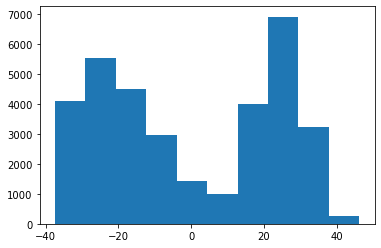

In [20]:
plt.hist(E[:,0])
plt.show()

In [33]:
# get decomposition of K*EEt 
# i.e. get Li's such that K*EEt = L1L1t + L2L2t + ..
[U, S, _] = economic_svd(E)
del _
us = U * S
Ls = [ddot(us[:,i], L_expanded) for i in range(us.shape[1])]
del us

In [28]:
# Phenotype
phenotype_file = input_files_dir+"phenotype.csv.pkl"
phenotype = pd.read_pickle(phenotype_file)
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 34256)
Phenotype shape AFTER selection: (11231, 33964)


In [24]:
# Filter on specific gene-SNP pairs
# eQTL from endodiff (ips+mesendo+defendo)
endo_eqtl_file = input_files_dir+"endodiff_eqtl_allconditions_FDR10pct.csv"
endo_eqtl = pd.read_csv(endo_eqtl_file, index_col = False)
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()

In [36]:
len(genes)

230

In [39]:
# set up model
# starting with (fixed effect) covariates
n_samples = phenotype.shape[1]
M = ones((n_samples, 1))

In [21]:
# column gaussianise environment(s)
E = quantile_gaussianize(E)

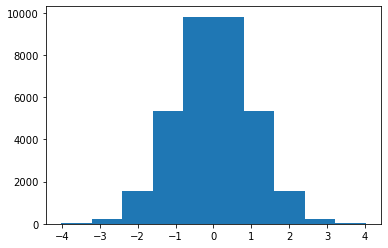

In [22]:
plt.hist(E[:,0])
plt.show()

In [57]:
i = 9
trait_name = genes[i]
trait_name

'ENSG00000213160_KLHL23'

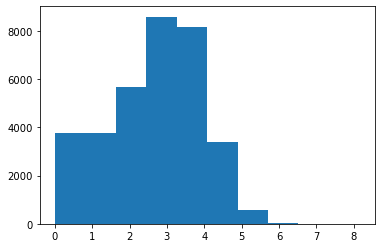

In [58]:
y = phenotype.sel(trait=trait_name)
plt.hist(y)
plt.show()

In [59]:
(y == 0).astype(int).sum()/len(y)

<xarray.DataArray ()>
array(0.04180897)
Coordinates:
    trait    <U22 'ENSG00000213160_KLHL23'

In [155]:
if (y == 0).astype(int).sum()/len(y)>0.3:
    print("Over 30 percent zeroes, skipping gene")

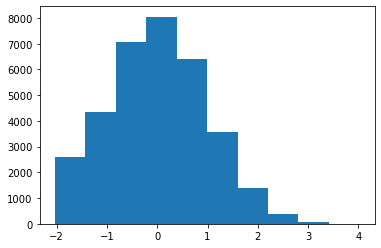

In [156]:
y = quantile_gaussianize(y)
plt.hist(y)
plt.show()

In [157]:
# select SNPs for a given gene
leads = endo_eqtl[endo_eqtl['feature']==trait_name]['snp_id'].unique()
leads

array(['2_170575157_G_A', '2_170617443_T_C', '2_170630637_A_G'],
      dtype=object)

In [158]:
G_tmp = G_exp[:,G_exp['snp'].isin(leads)]
G_tmp.shape   

(33964, 3)

In [159]:
print("Running for gene {}".format(trait_name))

Running for gene ENSG00000213160_KLHL23


In [160]:
# null model
slmm2 = StructLMM2(y.values, M, E, Ls)

In [161]:
# interaction test
pvals = slmm2.scan_interaction(G_tmp)[0]

100%|██████████| 3/3 [00:56<00:00, 18.76s/it]


In [162]:
pv = pd.DataFrame({"chrom":G_tmp.chrom.values,
               "pv":pvals,
               "variant":G_tmp.snp.values})

In [163]:
# ENSG00000213160_KLHL23
pv.head()

,chrom,pv,variant
0,2,0.003763,2_170575157_G_A
1,2,0.000168,2_170617443_T_C
2,2,0.000841,2_170630637_A_G


In [152]:
# ENSG00000240344_PPIL3
pv.head()

,chrom,pv,variant
0,2,0.067514,2_201742345_C_T
1,2,0.080321,2_201754063_T_C
2,2,0.367434,2_201774355_T_C


In [141]:
# ENSG00000136717_BIN1
pv.head()

,chrom,pv,variant
0,2,0.430905,2_127846505_T_C
1,2,0.406053,2_127859418_T_C
2,2,0.406053,2_127863029_C_T


In [130]:
# ENSG00000196208_GREB1
pv.head()

,chrom,pv,variant
0,2,0.314819,2_11720282_A_G
1,2,0.227613,2_11736305_G_A


In [119]:
# ENSG00000035141_FAM136A
pv.head()

,chrom,pv,variant
0,2,0.000011,2_70426325_C_T
1,2,0.012673,2_70502930_A_G
2,2,0.002110,2_70541419_A_G


In [108]:
# ENSG00000237651_C2orf74
pv.head()

,chrom,pv,variant
0,2,0.004901,2_61372507_A_G
1,2,0.042326,2_61381018_C_T
2,2,0.006464,2_61400816_G_A


In [97]:
# ENSG00000138032_PPM1B
pv.head()

,chrom,pv,variant
0,2,0.001197,2_44396235_T_G


In [86]:
# ENSG00000144120_TMEM177
pv.head()

,chrom,pv,variant
0,2,4.829657e-14,2_120438523_A_G


In [75]:
# ENSG00000183891_TTC32
pv.head()

,chrom,pv,variant
0,2,0.101845,2_20082172_T_C
1,2,0.018911,2_20090677_G_A


In [60]:
# ENSG00000229150_CRYGEP
pv.head()

,chrom,pv,variant
0,2,6.037734e-26,2_208977362_C_A
1,2,2.234445e-22,2_208977797_G_T


In [63]:
len(Ls)

1

In [64]:
Ls[0].shape

(33964, 125)